In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Configuration settings
WEIGHTAGES = ["1.0-0.0", "0.5-0.5", "0.0-1.0"]  # Different weightages to test
AGENTS = ["specialist", "generalist"]  # The two types of agents
ENVIRONMENT = "MOLavaGridRoom"

In [14]:
def process_video(video_path, grid_size=13):
    cap = cv2.VideoCapture(video_path)
    visit_counts = np.zeros((grid_size, grid_size))
    total_frames = 0

    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        total_frames += 1
        
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv_frame, lower_red, upper_red)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            
            grid_x = int(x / (frame.shape[1] / grid_size))
            grid_y = int(y / (frame.shape[0] / grid_size))
            
            if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
                visit_counts[grid_y, grid_x] += 1

    cap.release()
    return visit_counts, total_frames

def compile_heatmap(video_paths, grid_size=13, max_frames=1):
    total_visit_counts = np.zeros((grid_size, grid_size))
    
    for video_path in video_paths:
        visit_counts, total_frames = process_video(video_path, grid_size)
        normalized_counts = (visit_counts / max(total_frames, 1)) * max_frames
        total_visit_counts += normalized_counts
    
    return total_visit_counts

def extract_static_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        raise ValueError("Unable to read the video or extract a frame.")
    
    return frame

def plot_combined_heatmaps(heatmaps_dict, original_frames_dict, weightages, agents, opacity=0.9):
    fig, axes = plt.subplots(2, len(weightages), figsize=(7.9, 4.9), constrained_layout=True)

    # Find the max visit count across all heatmaps for consistent normalization
    max_visit_count = max(np.max(heatmap) for agent in agents for heatmap in heatmaps_dict[agent])

    for row, agent in enumerate(agents):
        for col, weightage in enumerate(weightages):
            ax = axes[row, col]
            heatmap = heatmaps_dict[agent][col]
            original_frame = original_frames_dict[agent][col]
            
            adjusted_visit_counts = np.log1p(heatmap) * 0.8  # Apply log transformation and scaling

            # Resize and normalize the heatmap
            heatmap_resized = cv2.resize(adjusted_visit_counts, (original_frame.shape[1], original_frame.shape[0]))
            heatmap_normalized = heatmap_resized / np.max(heatmap_resized)

            colored_heatmap = plt.cm.viridis(heatmap_normalized)[:, :, :3]
            colored_heatmap = (colored_heatmap * 255).astype(np.uint8)
            colored_heatmap_bgr = cv2.cvtColor(colored_heatmap, cv2.COLOR_RGB2BGR)

            # Blend heatmap with the original frame
            alpha_channel = heatmap_normalized * opacity
            original_frame_rgba = cv2.cvtColor(original_frame, cv2.COLOR_BGR2BGRA)
            colored_heatmap_rgba = np.dstack((colored_heatmap_bgr, (alpha_channel * 255).astype(np.uint8)))

            for y in range(colored_heatmap_rgba.shape[0]):
                for x in range(colored_heatmap_rgba.shape[1]):
                    alpha = colored_heatmap_rgba[y, x, 3] / 255.0
                    if alpha > 0:
                        original_frame_rgba[y, x, :3] = (1 - alpha) * original_frame_rgba[y, x, :3] + alpha * colored_heatmap_rgba[y, x, :3]

            final_overlay = cv2.cvtColor(original_frame_rgba, cv2.COLOR_BGRA2BGR)

            # Plot the heatmap
            ax.imshow(cv2.cvtColor(final_overlay, cv2.COLOR_BGR2RGB))
            if row == 0:  # Set the title only for the first row (Specialist)
                ax.set_title(f"Lava-Time: {weightage}", fontsize=16)
            
            # Set y-label for the first column of each row
            if col == 0:
                ax.set_ylabel(agent.capitalize(), fontsize=16, labelpad=10, rotation=90)
            
            # Remove x-ticks and y-ticks
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            

    # Add a colorbar shared by all subplots, spanning the entire height of the figure
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=np.log1p(max_visit_count) * 0.8)),
                        ax=axes, orientation='vertical', fraction=0.05, pad=0.04, aspect=30)
    cbar.set_label('Visit Count', fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    plt.savefig(f'images/{ENVIRONMENT}_Heatmap.svg', format='svg', bbox_inches='tight')
    plt.show()

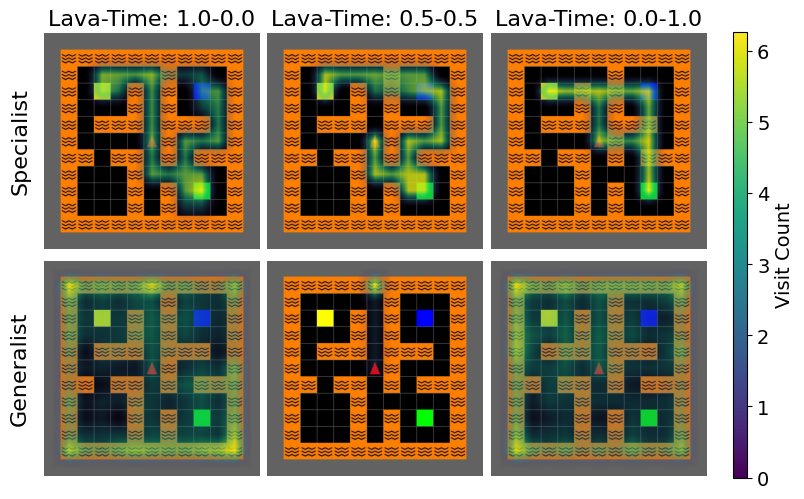

In [15]:
heatmaps_dict = {agent: [] for agent in AGENTS}
original_frames_dict = {agent: [] for agent in AGENTS}
max_frames_across_all_videos = 0

# First pass to find the longest video across all weightages and agents
for agent in AGENTS:
    for weightage in WEIGHTAGES:
        video_folder = f"videos/MOLavaGridDR/{ENVIRONMENT}/{agent}/{weightage}/"
        all_files = os.listdir(video_folder)
        video_files = [os.path.join(video_folder, f) for f in all_files if f.endswith(('.mp4'))]
        
        for video_file in video_files:
            _, total_frames = process_video(video_file)
            if total_frames > max_frames_across_all_videos:
                max_frames_across_all_videos = total_frames

# Second pass to compile heatmaps for each agent and weightage
for agent in AGENTS:
    for weightage in WEIGHTAGES:
        video_folder = f"videos/MOLavaGridDR/{ENVIRONMENT}/{agent}/{weightage}/"
        all_files = os.listdir(video_folder)
        video_files = [os.path.join(video_folder, f) for f in all_files if f.endswith(('.mp4'))]
        
        # Extract the original frame from the first video
        original_frame = extract_static_frame(video_files[0])
        original_frames_dict[agent].append(original_frame)
        
        # Compile visit counts from all videos
        compiled_visit_counts = compile_heatmap(video_files, grid_size=13, max_frames=max_frames_across_all_videos)
        heatmaps_dict[agent].append(compiled_visit_counts)

plot_combined_heatmaps(heatmaps_dict, original_frames_dict, WEIGHTAGES, AGENTS)